### Experiment with Transformer based model for PAMAP2 ZSL training
__Relative Positional Encoding based Transformer Encoder__ \
__Word Embedding Semantic Space__ \
_Objectives_ :
- transformer semantic feature output model hyper-param tuning
- 5-fold cross-validation tuning
- data normalization / not
- positional encoding 
- loss function tuning 

In [1]:
import os 
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import torch 
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

from src.datasets.data import PAMAP2Reader
from src.datasets.dataset import PAMAP2Dataset
from src.datasets.utils import load_attribute

from src.models.ts_transformer import RelativeGlobalAttention, ZSLHARNet
from src.models.loss import FeatureLoss, AttributeLoss 

from src.utils.analysis import action_evaluator
from src.running import train_step, eval_step

In [2]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "RelativeGlobalAttention",
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 64,
    "n_actions": 18,
    "folding": True,
    "fold_classes": [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']],
    "lr": 0.001,
    "n_epochs": 20,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    "loss_alpha": 0.8,
    # model configs
    "d_model": 128, 
    "num_heads": 8,
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 200,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

In [3]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# import PAMAP2 dataset
dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\HAR-ZSL-XAI\src\datasets\data.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [5]:
# import PAMAP2 attributes
activity_dict, attribute_dict, attr_mat = load_attribute('./data/PAMAP2_Dataset/PAMAP2_attributes.json')
_, attr_size = attr_mat.shape

In [6]:
# import action features
# feat_size = 64
# n_actions = 18 
# feat_mat = np.random.randn(n_actions, feat_size) 

# Load Glove-50 word embedding features 
feat_mat = np.load('./data/PAMAP2_Dataset/glove_features.npy')
n_actions, feat_size = feat_mat.shape

In [7]:
# run 5-fold running
fold_classes = config['fold_classes']
fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]


eval: 100%|██████████| 26/26 [00:00<00:00, 68.51batch/s, loss=0.48]


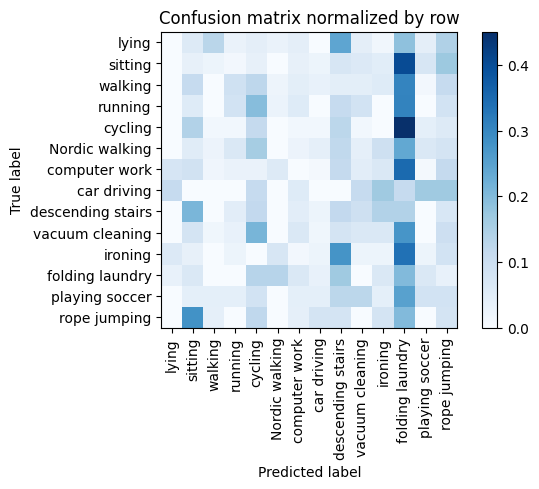

Training Epoch:   5%|▌         | 1/20 [00:04<01:20,  4.25s/it]

Overall accuracy: 0.043

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.000      0.000      0.000      0.130        106|	 folding laundry: 0.349,	rope jumping: 0.113,	descending stairs: 0.113,	
          walking       0.000      0.000      0.000      0.109         89|	 folding laundry: 0.303,	cycling: 0.124,	rope jumping: 0.112,	
          ironing       0.045      0.024      0.031      0.102         83|	 folding laundry: 0.337,	descending stairs: 0.277,	rope jumping: 0.084,	
          sitting       0.043      0.037      0.040      0.101         82|	 folding laundry: 0.402,	rope jumping: 0.171,	playing soccer: 0.073,	
   Nordic walking       0.000      0.000      0.000      0.093         76|	 folding laundry: 0.237,	cycling: 0.158,	descending stairs: 0.118,	
          cycling       0.105      0.113      0.109      0.087         71|	 folding laundry: 0.451,	sitting: 0.141,	descending stairs: 0.127,	
            lying

eval: 100%|██████████| 26/26 [00:00<00:00, 74.71batch/s, loss=0.517]


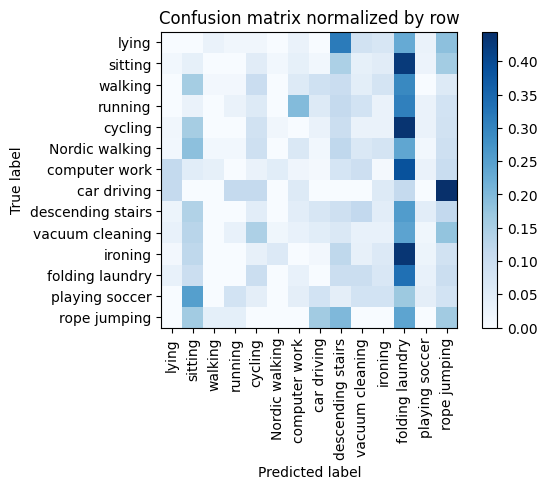

Training Epoch:  10%|█         | 2/20 [00:07<01:01,  3.42s/it]

Overall accuracy: 0.048

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.065      0.019      0.029      0.130        106|	 folding laundry: 0.387,	lying: 0.113,	rope jumping: 0.104,	
          walking       0.111      0.011      0.020      0.109         89|	 folding laundry: 0.292,	sitting: 0.157,	descending stairs: 0.101,	
          ironing       0.125      0.060      0.081      0.102         83|	 folding laundry: 0.434,	descending stairs: 0.120,	sitting: 0.120,	
          sitting       0.035      0.037      0.036      0.101         82|	 folding laundry: 0.427,	rope jumping: 0.159,	descending stairs: 0.146,	
   Nordic walking       0.000      0.000      0.000      0.093         76|	 folding laundry: 0.237,	sitting: 0.184,	descending stairs: 0.118,	
          cycling       0.115      0.085      0.098      0.087         71|	 folding laundry: 0.437,	sitting: 0.155,	descending stairs: 0.099,	
            lying       0.

eval: 100%|██████████| 26/26 [00:00<00:00, 69.52batch/s, loss=0.486]


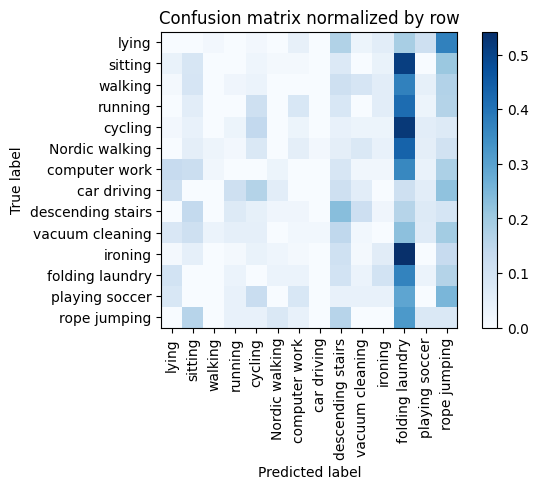

Training Epoch:  15%|█▌        | 3/20 [00:09<00:54,  3.18s/it]

Overall accuracy: 0.056

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.000      0.000      0.000      0.130        106|	 folding laundry: 0.358,	rope jumping: 0.179,	lying: 0.132,	
          walking       0.000      0.000      0.000      0.109         89|	 folding laundry: 0.371,	rope jumping: 0.169,	descending stairs: 0.112,	
          ironing       0.161      0.060      0.088      0.102         83|	 folding laundry: 0.542,	rope jumping: 0.133,	descending stairs: 0.108,	
          sitting       0.121      0.085      0.100      0.101         82|	 folding laundry: 0.512,	rope jumping: 0.207,	
   Nordic walking       0.000      0.000      0.000      0.093         76|	 folding laundry: 0.434,	rope jumping: 0.105,	vacuum cleaning: 0.079,	
          cycling       0.244      0.141      0.179      0.087         71|	 folding laundry: 0.521,	rope jumping: 0.070,	
            lying       0.000      0.000      0.000      0.0

eval: 100%|██████████| 26/26 [00:00<00:00, 64.84batch/s, loss=0.49]


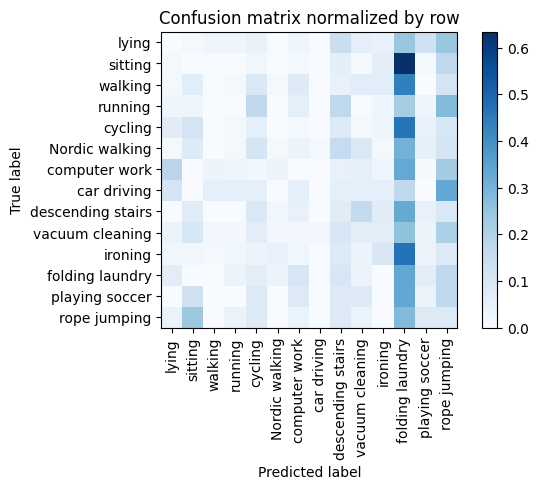

Training Epoch:  20%|██        | 4/20 [00:12<00:49,  3.11s/it]

Overall accuracy: 0.040

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.000      0.000      0.000      0.130        106|	 folding laundry: 0.330,	rope jumping: 0.226,	lying: 0.179,	
          walking       0.000      0.000      0.000      0.109         89|	 folding laundry: 0.438,	rope jumping: 0.112,	cycling: 0.090,	
          ironing       0.216      0.096      0.133      0.102         83|	 folding laundry: 0.470,	rope jumping: 0.084,	
          sitting       0.000      0.000      0.000      0.101         82|	 folding laundry: 0.634,	rope jumping: 0.171,	ironing: 0.061,	
   Nordic walking       0.077      0.013      0.022      0.093         76|	 folding laundry: 0.303,	descending stairs: 0.158,	rope jumping: 0.105,	
          cycling       0.078      0.056      0.066      0.087         71|	 folding laundry: 0.465,	sitting: 0.113,	rope jumping: 0.099,	
            lying       0.000      0.000      0.000      0.086

eval: 100%|██████████| 26/26 [00:00<00:00, 73.86batch/s, loss=0.478]


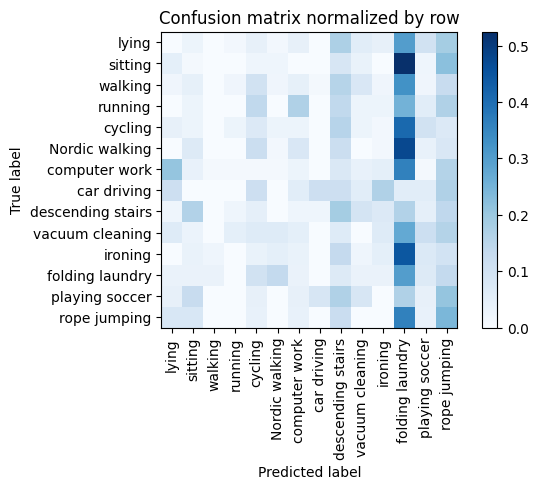

Training Epoch:  25%|██▌       | 5/20 [00:15<00:44,  2.99s/it]

Overall accuracy: 0.049

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.086      0.028      0.043      0.130        106|	 folding laundry: 0.358,	lying: 0.208,	rope jumping: 0.160,	
          walking       0.000      0.000      0.000      0.109         89|	 folding laundry: 0.326,	descending stairs: 0.157,	rope jumping: 0.124,	
          ironing       0.143      0.048      0.072      0.102         83|	 folding laundry: 0.446,	descending stairs: 0.133,	rope jumping: 0.096,	
          sitting       0.027      0.012      0.017      0.101         82|	 folding laundry: 0.524,	rope jumping: 0.220,	descending stairs: 0.085,	
   Nordic walking       0.048      0.013      0.021      0.093         76|	 folding laundry: 0.474,	descending stairs: 0.118,	cycling: 0.118,	
          cycling       0.100      0.070      0.083      0.087         71|	 folding laundry: 0.408,	descending stairs: 0.155,	playing soccer: 0.099,	
         

eval: 100%|██████████| 26/26 [00:00<00:00, 70.84batch/s, loss=0.507]


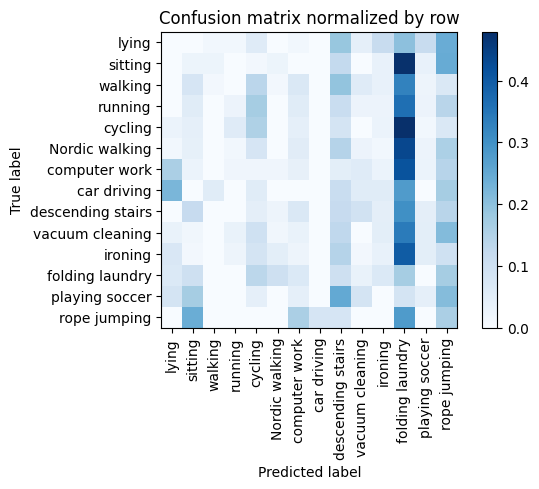

Training Epoch:  30%|███       | 6/20 [00:18<00:40,  2.91s/it]

Overall accuracy: 0.045

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.118      0.038      0.057      0.130        106|	 folding laundry: 0.415,	lying: 0.160,	rope jumping: 0.142,	
          walking       0.200      0.011      0.021      0.109         89|	 folding laundry: 0.326,	descending stairs: 0.191,	cycling: 0.135,	
          ironing       0.094      0.036      0.052      0.102         83|	 folding laundry: 0.398,	descending stairs: 0.145,	rope jumping: 0.096,	
          sitting       0.050      0.024      0.033      0.101         82|	 folding laundry: 0.476,	rope jumping: 0.244,	descending stairs: 0.122,	
   Nordic walking       0.000      0.000      0.000      0.093         76|	 folding laundry: 0.434,	rope jumping: 0.158,	descending stairs: 0.145,	
          cycling       0.175      0.155      0.164      0.087         71|	 folding laundry: 0.479,	descending stairs: 0.085,	
            lying       0.000   

eval: 100%|██████████| 26/26 [00:00<00:00, 75.80batch/s, loss=0.474]


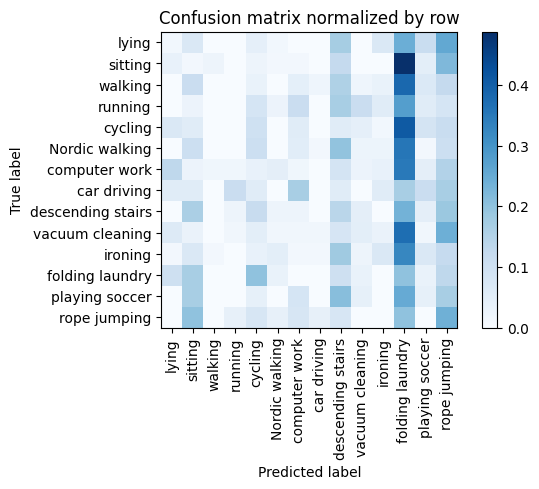

Training Epoch:  35%|███▌      | 7/20 [00:21<00:37,  2.86s/it]

Overall accuracy: 0.048

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.069      0.019      0.030      0.130        106|	 folding laundry: 0.349,	rope jumping: 0.151,	lying: 0.132,	
          walking       0.000      0.000      0.000      0.109         89|	 folding laundry: 0.382,	descending stairs: 0.157,	rope jumping: 0.124,	
          ironing       0.231      0.072      0.110      0.102         83|	 folding laundry: 0.325,	descending stairs: 0.181,	rope jumping: 0.120,	
          sitting       0.016      0.012      0.014      0.101         82|	 folding laundry: 0.488,	rope jumping: 0.220,	descending stairs: 0.122,	
   Nordic walking       0.000      0.000      0.000      0.093         76|	 folding laundry: 0.355,	descending stairs: 0.197,	rope jumping: 0.105,	
          cycling       0.137      0.099      0.115      0.087         71|	 folding laundry: 0.408,	rope jumping: 0.113,	
            lying       0.031   

eval: 100%|██████████| 26/26 [00:00<00:00, 70.65batch/s, loss=0.487]


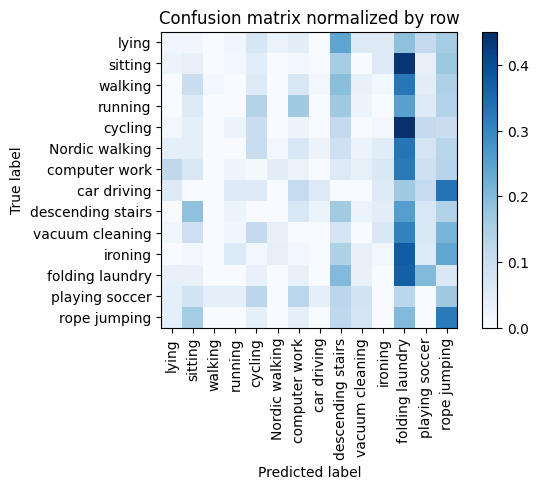

Training Epoch:  40%|████      | 8/20 [00:24<00:34,  2.85s/it]

Overall accuracy: 0.054

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.081      0.028      0.042      0.130        106|	 folding laundry: 0.321,	rope jumping: 0.132,	lying: 0.123,	
          walking       0.500      0.011      0.022      0.109         89|	 folding laundry: 0.326,	descending stairs: 0.191,	rope jumping: 0.146,	
          ironing       0.033      0.012      0.018      0.102         83|	 folding laundry: 0.373,	rope jumping: 0.241,	descending stairs: 0.145,	
          sitting       0.060      0.037      0.045      0.101         82|	 folding laundry: 0.439,	rope jumping: 0.171,	descending stairs: 0.159,	
   Nordic walking       0.077      0.013      0.022      0.093         76|	 folding laundry: 0.329,	rope jumping: 0.132,	cycling: 0.105,	
          cycling       0.143      0.099      0.117      0.087         71|	 folding laundry: 0.451,	playing soccer: 0.113,	descending stairs: 0.113,	
            ly

eval: 100%|██████████| 26/26 [00:00<00:00, 72.22batch/s, loss=0.52]


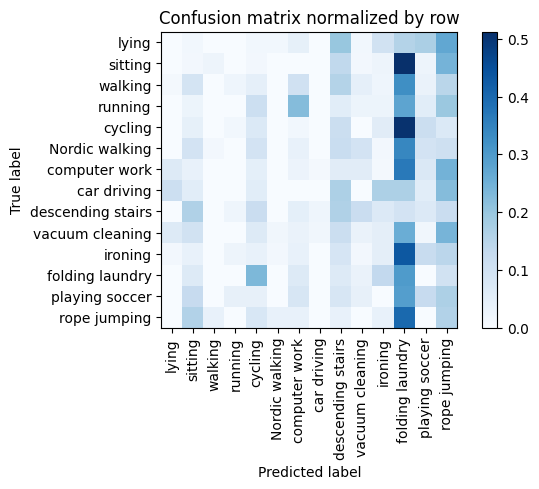

Training Epoch:  45%|████▌     | 9/20 [00:26<00:31,  2.84s/it]

Overall accuracy: 0.047

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.077      0.028      0.041      0.130        106|	 folding laundry: 0.368,	rope jumping: 0.245,	playing soccer: 0.075,	
          walking       0.000      0.000      0.000      0.109         89|	 folding laundry: 0.326,	descending stairs: 0.157,	rope jumping: 0.146,	
          ironing       0.111      0.048      0.067      0.102         83|	 folding laundry: 0.434,	rope jumping: 0.145,	playing soccer: 0.120,	
          sitting       0.020      0.012      0.015      0.101         82|	 folding laundry: 0.512,	rope jumping: 0.244,	descending stairs: 0.134,	
   Nordic walking       0.000      0.000      0.000      0.093         76|	 folding laundry: 0.342,	descending stairs: 0.118,	rope jumping: 0.105,	
          cycling       0.100      0.070      0.083      0.087         71|	 folding laundry: 0.507,	playing soccer: 0.113,	descending stairs: 0.113,

eval: 100%|██████████| 26/26 [00:00<00:00, 76.68batch/s, loss=0.468]


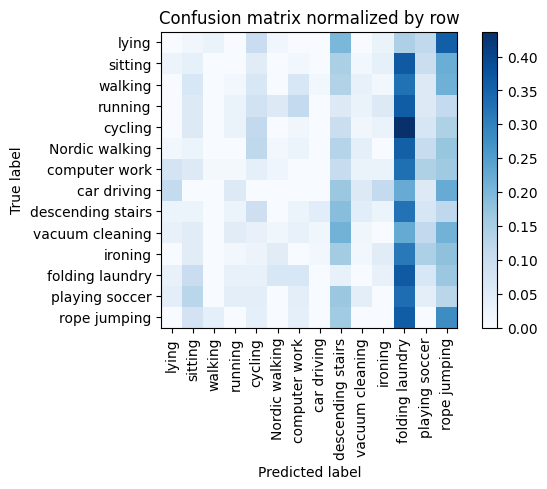

Training Epoch:  50%|█████     | 10/20 [00:29<00:28,  2.86s/it]

Overall accuracy: 0.055

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.000      0.000      0.000      0.130        106|	 folding laundry: 0.330,	rope jumping: 0.160,	playing soccer: 0.142,	
          walking       0.000      0.000      0.000      0.109         89|	 folding laundry: 0.326,	rope jumping: 0.213,	descending stairs: 0.135,	
          ironing       0.190      0.048      0.077      0.102         83|	 folding laundry: 0.313,	rope jumping: 0.181,	descending stairs: 0.157,	
          sitting       0.075      0.037      0.049      0.101         82|	 folding laundry: 0.366,	rope jumping: 0.220,	descending stairs: 0.146,	
   Nordic walking       0.077      0.013      0.022      0.093         76|	 folding laundry: 0.355,	rope jumping: 0.171,	descending stairs: 0.132,	
          cycling       0.154      0.113      0.130      0.087         71|	 folding laundry: 0.437,	rope jumping: 0.141,	
            lying      

eval: 100%|██████████| 26/26 [00:00<00:00, 73.03batch/s, loss=0.481]


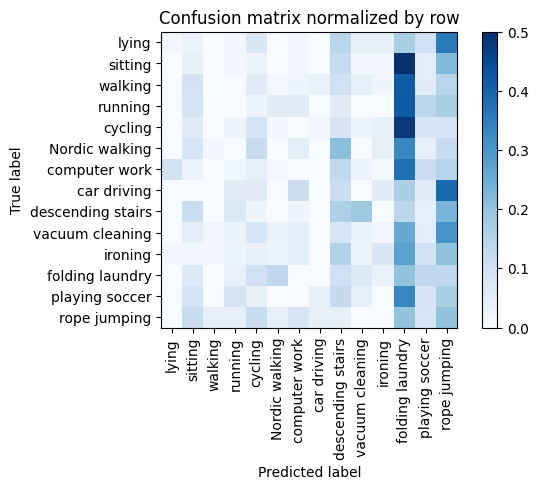

Training Epoch:  55%|█████▌    | 11/20 [00:32<00:25,  2.82s/it]

Overall accuracy: 0.047

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.000      0.000      0.000      0.130        106|	 folding laundry: 0.377,	rope jumping: 0.151,	descending stairs: 0.132,	
          walking       0.000      0.000      0.000      0.109         89|	 folding laundry: 0.416,	rope jumping: 0.146,	descending stairs: 0.101,	
          ironing       0.273      0.072      0.114      0.102         83|	 folding laundry: 0.277,	rope jumping: 0.205,	descending stairs: 0.157,	
          sitting       0.067      0.037      0.047      0.101         82|	 folding laundry: 0.500,	rope jumping: 0.220,	descending stairs: 0.122,	
   Nordic walking       0.000      0.000      0.000      0.093         76|	 folding laundry: 0.329,	descending stairs: 0.211,	rope jumping: 0.118,	
          cycling       0.122      0.085      0.100      0.087         71|	 folding laundry: 0.479,	rope jumping: 0.085,	playing soccer: 0.085

eval: 100%|██████████| 26/26 [00:00<00:00, 76.92batch/s, loss=0.45]


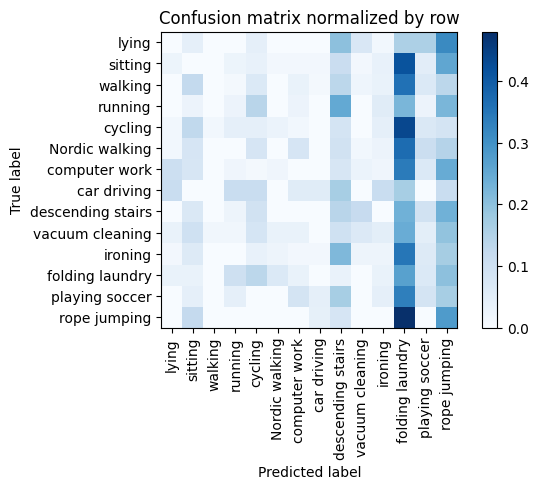

Training Epoch:  60%|██████    | 12/20 [00:35<00:22,  2.83s/it]

Overall accuracy: 0.042

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.000      0.000      0.000      0.130        106|	 folding laundry: 0.340,	rope jumping: 0.245,	lying: 0.104,	
          walking       0.000      0.000      0.000      0.109         89|	 folding laundry: 0.360,	rope jumping: 0.135,	descending stairs: 0.135,	
          ironing       0.080      0.024      0.037      0.102         83|	 folding laundry: 0.349,	descending stairs: 0.217,	rope jumping: 0.169,	
          sitting       0.000      0.000      0.000      0.101         82|	 folding laundry: 0.415,	rope jumping: 0.256,	descending stairs: 0.110,	
   Nordic walking       0.000      0.000      0.000      0.093         76|	 folding laundry: 0.368,	rope jumping: 0.145,	playing soccer: 0.105,	
          cycling       0.067      0.042      0.052      0.087         71|	 folding laundry: 0.437,	sitting: 0.127,	rope jumping: 0.085,	
            lying  

eval: 100%|██████████| 26/26 [00:00<00:00, 74.93batch/s, loss=0.54]


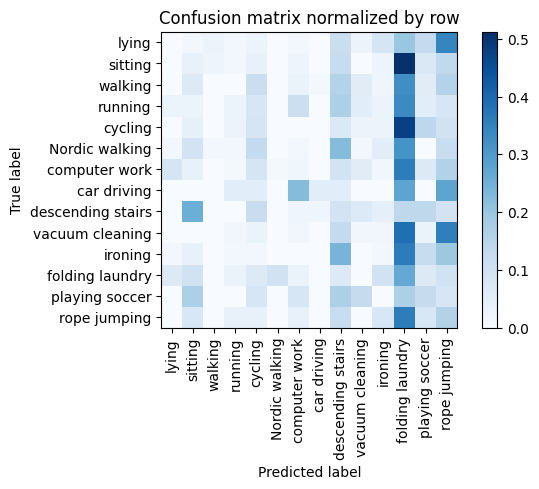

Training Epoch:  65%|██████▌   | 13/20 [00:38<00:20,  2.88s/it]

Overall accuracy: 0.042

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.087      0.019      0.031      0.130        106|	 folding laundry: 0.358,	rope jumping: 0.160,	descending stairs: 0.094,	
          walking       0.000      0.000      0.000      0.109         89|	 folding laundry: 0.326,	rope jumping: 0.157,	descending stairs: 0.157,	
          ironing       0.036      0.012      0.018      0.102         83|	 folding laundry: 0.361,	descending stairs: 0.241,	rope jumping: 0.193,	
          sitting       0.062      0.037      0.046      0.101         82|	 folding laundry: 0.512,	rope jumping: 0.134,	descending stairs: 0.122,	
   Nordic walking       0.000      0.000      0.000      0.093         76|	 folding laundry: 0.316,	descending stairs: 0.224,	cycling: 0.132,	
          cycling       0.105      0.085      0.094      0.087         71|	 folding laundry: 0.479,	playing soccer: 0.141,	rope jumping: 0.099,	
  

eval: 100%|██████████| 26/26 [00:00<00:00, 71.69batch/s, loss=0.505]


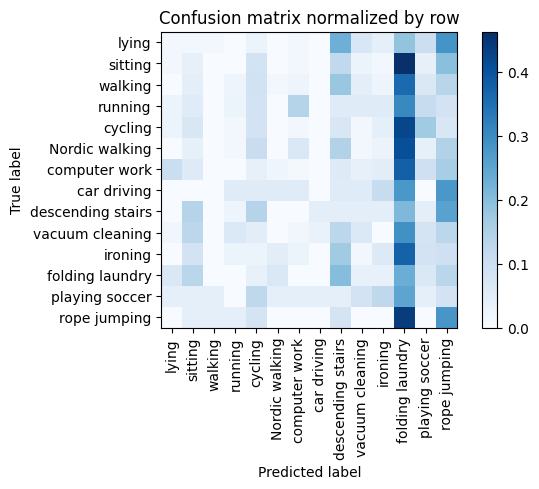

Training Epoch:  70%|███████   | 14/20 [00:41<00:17,  2.98s/it]

Overall accuracy: 0.047

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.048      0.009      0.016      0.130        106|	 folding laundry: 0.377,	rope jumping: 0.160,	lying: 0.104,	
          walking       0.000      0.000      0.000      0.109         89|	 folding laundry: 0.360,	descending stairs: 0.180,	rope jumping: 0.135,	
          ironing       0.161      0.060      0.088      0.102         83|	 folding laundry: 0.373,	descending stairs: 0.169,	rope jumping: 0.096,	
          sitting       0.059      0.037      0.045      0.101         82|	 folding laundry: 0.463,	rope jumping: 0.195,	descending stairs: 0.122,	
   Nordic walking       0.000      0.000      0.000      0.093         76|	 folding laundry: 0.408,	rope jumping: 0.145,	descending stairs: 0.145,	
          cycling       0.107      0.085      0.094      0.087         71|	 folding laundry: 0.423,	playing soccer: 0.169,	
            lying       0.050 

eval: 100%|██████████| 26/26 [00:00<00:00, 62.65batch/s, loss=0.491]


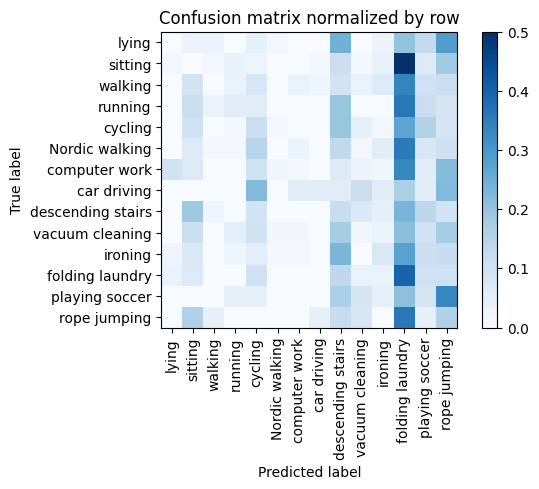

Training Epoch:  75%|███████▌  | 15/20 [00:44<00:15,  3.06s/it]

Overall accuracy: 0.052

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.111      0.009      0.017      0.130        106|	 folding laundry: 0.330,	rope jumping: 0.217,	cycling: 0.094,	
          walking       0.000      0.000      0.000      0.109         89|	 folding laundry: 0.337,	rope jumping: 0.112,	playing soccer: 0.101,	
          ironing       0.194      0.072      0.105      0.102         83|	 folding laundry: 0.277,	descending stairs: 0.229,	rope jumping: 0.120,	
          sitting       0.000      0.000      0.000      0.101         82|	 folding laundry: 0.500,	rope jumping: 0.183,	descending stairs: 0.110,	
   Nordic walking       0.000      0.000      0.000      0.093         76|	 folding laundry: 0.355,	cycling: 0.145,	descending stairs: 0.132,	
          cycling       0.123      0.113      0.118      0.087         71|	 folding laundry: 0.268,	descending stairs: 0.197,	playing soccer: 0.155,	
          

eval: 100%|██████████| 26/26 [00:00<00:00, 65.99batch/s, loss=0.483]


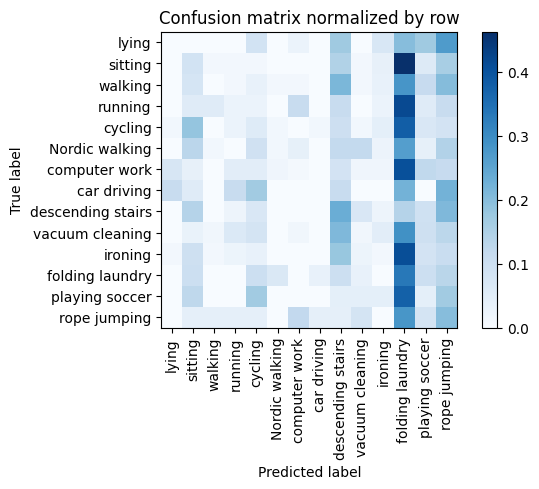

Training Epoch:  80%|████████  | 16/20 [00:47<00:12,  3.03s/it]

Overall accuracy: 0.052

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.067      0.009      0.017      0.130        106|	 folding laundry: 0.406,	playing soccer: 0.123,	rope jumping: 0.113,	
          walking       0.000      0.000      0.000      0.109         89|	 folding laundry: 0.281,	descending stairs: 0.213,	rope jumping: 0.202,	
          ironing       0.040      0.012      0.019      0.102         83|	 folding laundry: 0.410,	descending stairs: 0.181,	rope jumping: 0.108,	
          sitting       0.104      0.085      0.094      0.101         82|	 folding laundry: 0.463,	rope jumping: 0.159,	descending stairs: 0.146,	
   Nordic walking       0.143      0.013      0.024      0.093         76|	 folding laundry: 0.263,	rope jumping: 0.145,	sitting: 0.132,	
          cycling       0.082      0.056      0.067      0.087         71|	 folding laundry: 0.380,	sitting: 0.183,	descending stairs: 0.099,	
            

eval: 100%|██████████| 26/26 [00:00<00:00, 60.47batch/s, loss=0.535]


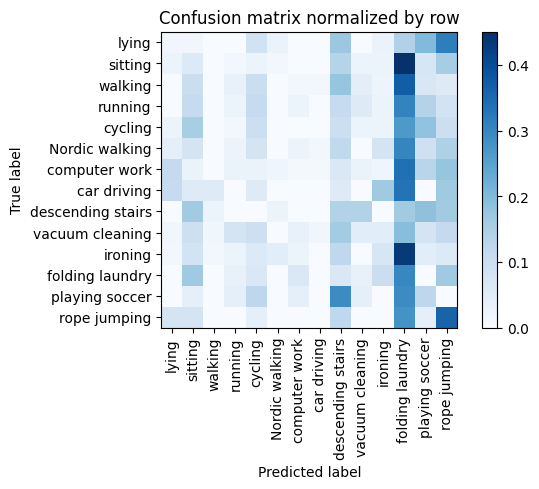

Training Epoch:  85%|████████▌ | 17/20 [00:50<00:09,  3.01s/it]

Overall accuracy: 0.063

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.083      0.009      0.017      0.130        106|	 folding laundry: 0.340,	rope jumping: 0.179,	playing soccer: 0.132,	
          walking       0.000      0.000      0.000      0.109         89|	 folding laundry: 0.371,	descending stairs: 0.180,	cycling: 0.101,	
          ironing       0.188      0.072      0.104      0.102         83|	 folding laundry: 0.434,	descending stairs: 0.120,	sitting: 0.084,	
          sitting       0.074      0.061      0.067      0.101         82|	 folding laundry: 0.451,	rope jumping: 0.159,	descending stairs: 0.134,	
   Nordic walking       0.000      0.000      0.000      0.093         76|	 folding laundry: 0.303,	rope jumping: 0.145,	descending stairs: 0.118,	
          cycling       0.127      0.099      0.111      0.087         71|	 folding laundry: 0.268,	playing soccer: 0.183,	sitting: 0.155,	
            lyi

eval: 100%|██████████| 26/26 [00:00<00:00, 73.24batch/s, loss=0.501]


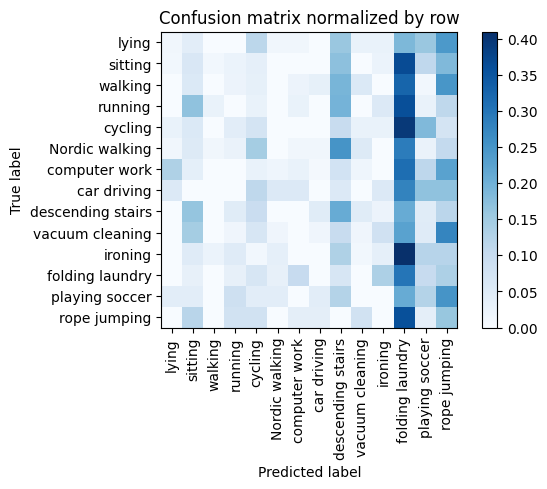

Training Epoch:  90%|█████████ | 18/20 [00:53<00:05,  3.00s/it]

Overall accuracy: 0.053

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.231      0.028      0.050      0.130        106|	 folding laundry: 0.311,	rope jumping: 0.226,	lying: 0.132,	
          walking       0.000      0.000      0.000      0.109         89|	 folding laundry: 0.326,	rope jumping: 0.247,	descending stairs: 0.191,	
          ironing       0.136      0.036      0.057      0.102         83|	 folding laundry: 0.410,	descending stairs: 0.133,	rope jumping: 0.120,	
          sitting       0.089      0.061      0.072      0.101         82|	 folding laundry: 0.366,	rope jumping: 0.183,	descending stairs: 0.171,	
   Nordic walking       0.000      0.000      0.000      0.093         76|	 folding laundry: 0.289,	descending stairs: 0.250,	cycling: 0.145,	
          cycling       0.100      0.070      0.083      0.087         71|	 folding laundry: 0.394,	playing soccer: 0.183,	descending stairs: 0.099,	
         

eval: 100%|██████████| 26/26 [00:00<00:00, 67.50batch/s, loss=0.526]


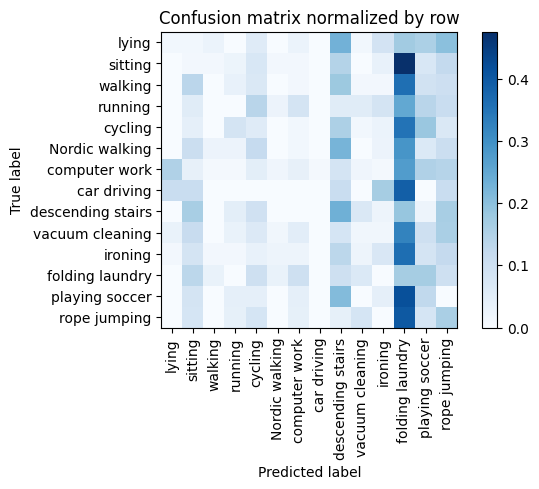

Training Epoch:  95%|█████████▌| 19/20 [00:57<00:03,  3.14s/it]

Overall accuracy: 0.048

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.174      0.038      0.062      0.130        106|	 folding laundry: 0.274,	playing soccer: 0.151,	lying: 0.151,	
          walking       0.000      0.000      0.000      0.109         89|	 folding laundry: 0.360,	descending stairs: 0.180,	sitting: 0.135,	
          ironing       0.200      0.072      0.106      0.102         83|	 folding laundry: 0.361,	descending stairs: 0.133,	rope jumping: 0.120,	
          sitting       0.016      0.012      0.014      0.101         82|	 folding laundry: 0.476,	descending stairs: 0.146,	rope jumping: 0.122,	
   Nordic walking       0.000      0.000      0.000      0.093         76|	 folding laundry: 0.289,	descending stairs: 0.224,	cycling: 0.118,	
          cycling       0.071      0.056      0.063      0.087         71|	 folding laundry: 0.352,	playing soccer: 0.183,	descending stairs: 0.155,	
            

eval: 100%|██████████| 26/26 [00:00<00:00, 71.82batch/s, loss=0.505]


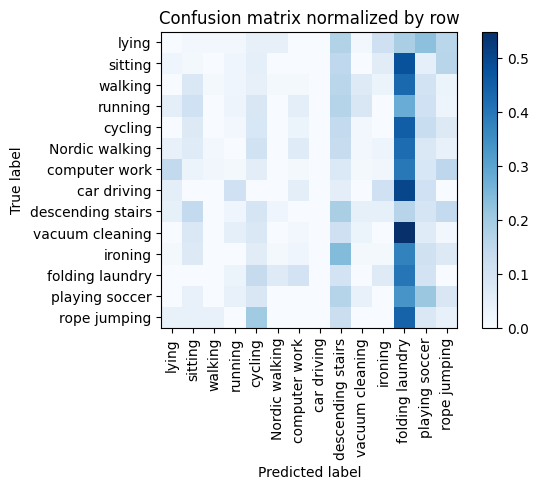

Overall accuracy: 0.048

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    computer work       0.056      0.009      0.016      0.130        106|	 folding laundry: 0.396,	rope jumping: 0.151,	lying: 0.142,	
          walking       0.167      0.011      0.021      0.109         89|	 folding laundry: 0.427,	descending stairs: 0.157,	playing soccer: 0.101,	
          ironing       0.037      0.012      0.018      0.102         83|	 folding laundry: 0.373,	descending stairs: 0.241,	playing soccer: 0.108,	
          sitting       0.022      0.012      0.016      0.101         82|	 folding laundry: 0.476,	rope jumping: 0.159,	descending stairs: 0.146,	
   Nordic walking       0.000      0.000      0.000      0.093         76|	 folding laundry: 0.421,	descending stairs: 0.132,	cycling: 0.105,	
          cycling       0.102      0.085      0.092      0.087         71|	 folding laundry: 0.451,	descending stairs: 0.141,	playing soccer: 0.127,	
     

eval: 100%|██████████| 28/28 [00:00<00:00, 70.07batch/s, loss=0.486]


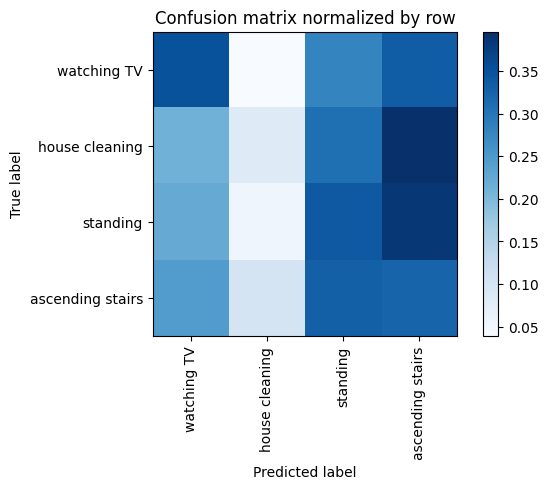

Overall accuracy: 0.253

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  house cleaning       0.387      0.083      0.137      0.329        288|	 ascending stairs: 0.396,	standing: 0.309,	watching TV: 0.212,	
        standing       0.344      0.339      0.342      0.323        283|	 ascending stairs: 0.385,	watching TV: 0.223,	
ascending stairs       0.176      0.324      0.228      0.201        176|	 standing: 0.330,	watching TV: 0.244,	
     watching TV       0.212      0.349      0.264      0.147        129|	 ascending stairs: 0.333,	standing: 0.279,	

----------------------------------------------------------------------------------------------------
     avg / total       0.305      0.253      0.240        1.0        876|	      

{'total_accuracy': 0.2534246575342466, 'precision': 0.2799793837194038, 'recall': 0.27381419846007116, 'f1': 0.2427916001037494}


In [8]:
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, resampling=True, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'])
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape
    # build train_dt 
    # print(seen_classes)
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=unseen_classes)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    
    # build model
    model = ZSLHARNet(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], ft_size=feat_size, attr_size=attr_size, max_len=seq_len)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    # loss_module = {'feature': FeatureLoss(), 'attribute': AttributeLoss()}
    loss_module = {'feature': MSELoss(), 'attribute': AttributeLoss()}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step(model, train_dl, optimizer, loss_module, config['loss_alpha'], device, class_names=[all_classes[i] for i in seen_classes], target_feat_met=train_dt.target_feat, phase='train', with_attr=True)
        eval_metrics = eval_step(model, eval_dl, loss_module, config['loss_alpha'], device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.target_feat, phase='eval', with_attrs=True, print_report=False)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    if best_acc == 0.0:
        best_model = deepcopy(model.state_dict())
    
    # replace by best model 
    model.load_state_dict(best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.target_feat, phase='eval')
    print(test_metrics)
    print("="*40)
    break